In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import os
from shutil import copy2
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import random

In [2]:
random.seed(2020)
# find all of the files in the directory
hlist=[]
ilist=[]

folders=["../data/skin_lesions/h-mal/", "../data/skin_lesions/org-mal/"]
lists=[hlist,ilist]
for folder, filelist in zip(folders, lists):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".png"):
                filelist.append(os.path.join(root, file))
                
print('Found ', len(hlist),' heatmap files.')
print('Found ', len(ilist),' org files.')

N_CLUSTERS = 4
IM_FEATURES = 10
H_FEATURES = 20
N_NEIGHBORS = 8

# select clustering algorithm
# 1 - spectral clustering
# 0 - kmeans
clustering_algorithm = 1

Found  884  heatmap files.
Found  884  org files.


100%|████████████████████████████████████████████████████████████████████████████████| 884/884 [00:10<00:00, 82.95it/s]

Loaded  884  heatmaps.
(2025,)
Loaded  884  images.


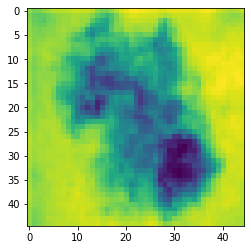

In [3]:
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import rescale
from sklearn.feature_extraction import image

heatmaps=[]
images=[]

# loading images
datasets = [heatmaps, images]
for files,dataset in zip(lists,datasets):
    for file in tqdm(files):
        np_image=[]
        np_image = np.array(Image.open(file))
        rescaled_heatmap = rescale(np_image, 0.2, mode="reflect")
        rescaled_heatmap=rescaled_heatmap[:,:,0]
        dataset.append(rescaled_heatmap.reshape(rescaled_heatmap.shape[0]*rescaled_heatmap.shape[1]))


print('Loaded ', len(heatmaps),' heatmaps.')
print(heatmaps[1].shape)
print('Loaded ', len(images),' images.')    
plt.imshow(rescaled_heatmap)

Visualize the resulting regions



In [4]:
# in this version of spray Isomap will be used also for dimensionalkity reduction
# hence n_components=20 
scaler = MinMaxScaler()
isomap = Isomap(n_neighbors=N_NEIGHBORS,n_components=H_FEATURES,eigen_solver='arpack',path_method='FW', neighbors_algorithm='brute')
h_isomap= isomap.fit_transform(heatmaps)
h_isomap = scaler.fit_transform(h_isomap)

isomap = Isomap(n_neighbors=N_NEIGHBORS,n_components=IM_FEATURES,eigen_solver='arpack',path_method='FW', neighbors_algorithm='brute')
im_isomap= isomap.fit_transform(images)
im_isomap = scaler.fit_transform(im_isomap)

In [5]:
def plot_results(N_CLUSTERS,h_isomap,im_isomap,labels):
    fig=plt.figure(figsize=(15, 8))
    ax = Axes3D(fig)
    for cluster in range(0,N_CLUSTERS):
        ax.scatter(h_isomap[labels==cluster,0],h_isomap[labels==cluster,1],h_isomap[labels==cluster,2])
    plt.show()

    fig=plt.figure(figsize=(15, 8))
    ax = Axes3D(fig)
    for cluster in range(0,N_CLUSTERS):
        ax.scatter(im_isomap[labels==cluster,0],im_isomap[labels==cluster,1],im_isomap[labels==cluster,2])
    plt.show()

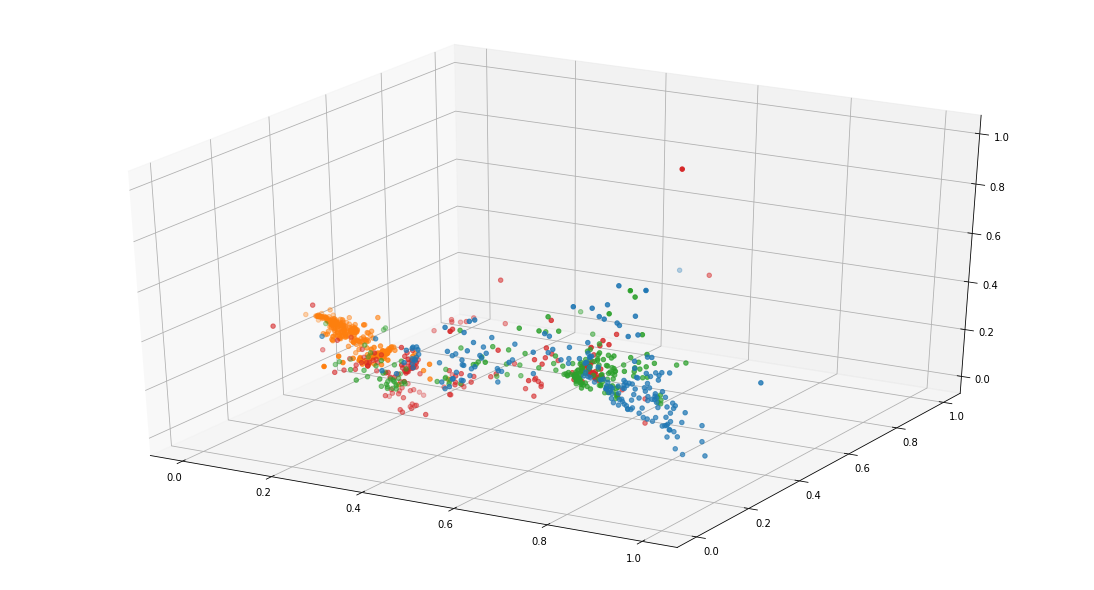

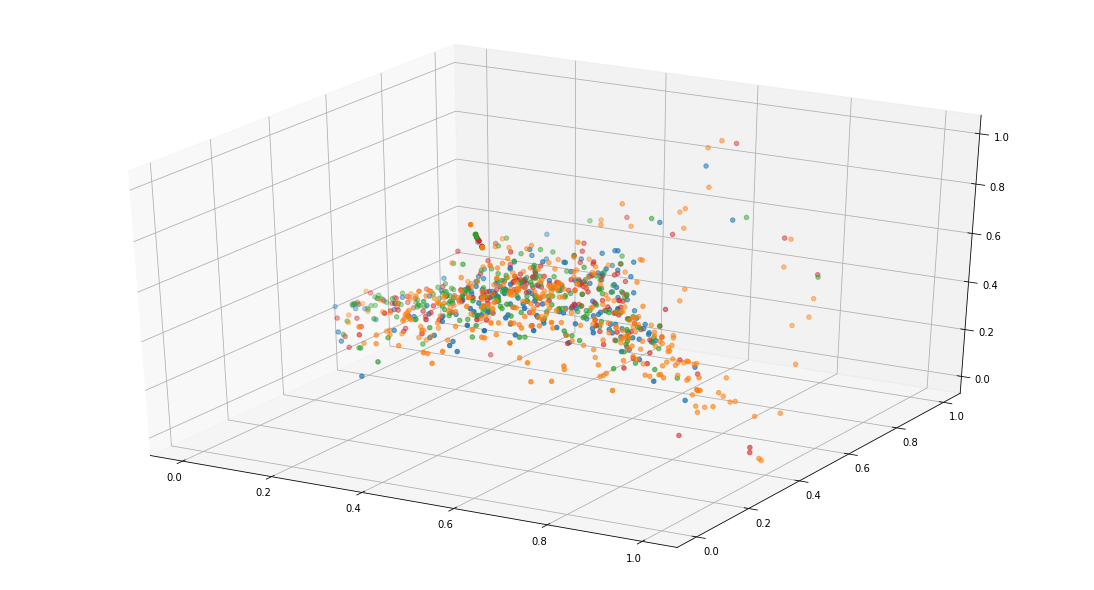

In [6]:
# cluster based on heatmaps
if clustering_algorithm == 0:
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(h_isomap)
    labels = kmeans.predict(h_isomap)
elif clustering_algorithm == 1:
    clustering = SpectralClustering(n_clusters=N_CLUSTERS,
                                    assign_labels="discretize",
                                    n_neighbors=N_NEIGHBORS,
                                    random_state=0).fit(h_isomap)
    labels = clustering.labels_

# plot results
plot_results(N_CLUSTERS,h_isomap,im_isomap,labels)

# copy results to experiments folder
for label, image in zip(labels, ilist):
    directory = "../experiments/spray_isomap/heatmaps/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(image, directory)

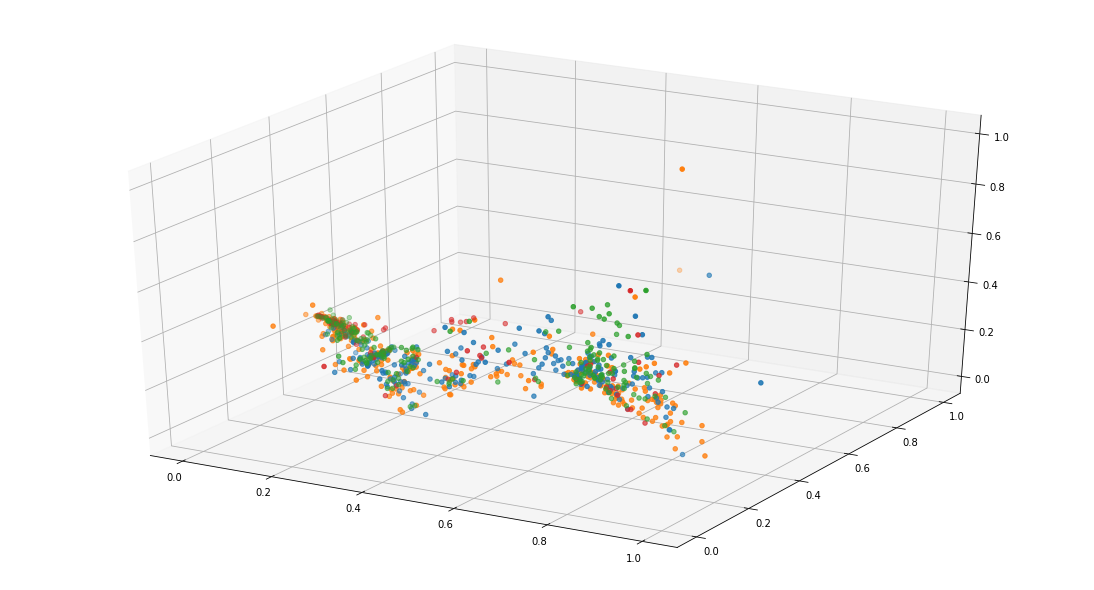

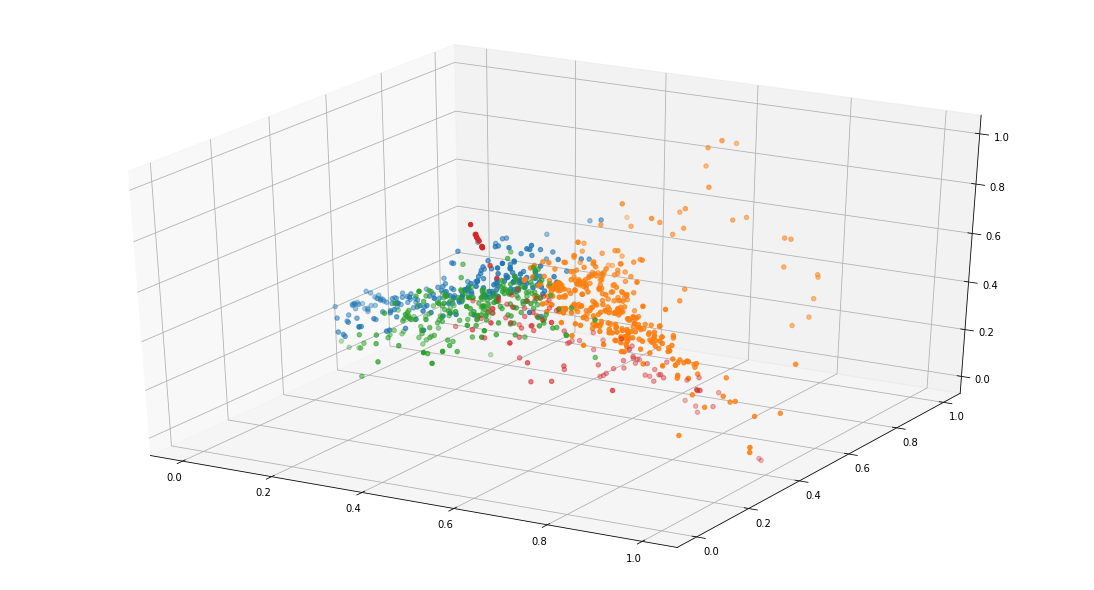

In [7]:
if clustering_algorithm == 0:
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(im_isomap)
    labels = kmeans.predict(im_isomap)
elif clustering_algorithm == 1:
    clustering = SpectralClustering(n_clusters=N_CLUSTERS,
                                    assign_labels="discretize",
                                    n_neighbors=N_NEIGHBORS,
                                    random_state=0).fit(im_isomap)
    labels = clustering.labels_

plot_results(N_CLUSTERS,h_isomap,im_isomap,labels)

# copy results to experiments folder
for label, image in zip(labels, ilist):
    directory = "../experiments/spray_isomap/images/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(image, directory)